<a href="https://colab.research.google.com/github/lorenzopallante/BiomeccanicaMultiscala/blob/main/LAB/08-SMD/08-SteeredMD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Laboratorio 8
**Enhanced Sampling: Steered Molecular Dynamics (SMD)**


Authors:
    
- Prof. Marco A. Deriu (marco.deriu@polito.it)
- Lorenzo Pallante (lorenzo.pallante@polito.it)
- Eric A. Zizzi (eric.zizzi@polito.it)
- Marcello Miceli (marcello.miceli@polito.it)
- Marco Cannariato (marco.cannariato@polito.it)

# Table of Contents

1. Gromacs Setup 
2. Steered Molecular Dynamics (SMD)
    2.1 Theory recap
    2.2 Practical session
    
**Learning outcomes:** 
Understand the basics and the main GROMACS settings to perform a Steered Molecular Dynamics simulation and evaluate results

# Setup

To update the maximum characters limit of the jupyter cells use the following line

In [ ]:
from notebook.services.config import ConfigManager
cm = ConfigManager().update('notebook', {'limit_output': 100000000})

If you don't have GROMACS and NGLView installed on your machine or if you are using **Google COLAB**, run the following lines

**This lines should be run at the beginning of each laboratory**

In [ ]:
#@title Installing GROMACS
!apt install gromacs &> /dev/null

In [ ]:
#@title Installing NGLview
!pip install nglview  &> /dev/null
!pip install simpletraj  &> /dev/null
from google.colab import output
output.enable_custom_widget_manager()

Clone files form GitHub if you are using COLAB

In [ ]:
# IF YOU ARE USING COLAB EXECUTE THIS CELL (to copy over data repository)
!git clone https://github.com/lorenzopallante/BiomeccanicaMultiscala.git
!mv BiomeccanicaMultiscala/LAB/08-SMD/* .

# Steered Molecular Dynamics

## Theory Recap

**Steered Molecular Dynamcis (SMD)** applies external steering forces, applying a **constraint** (e.g. a harmonic potential), that moves along a prescribed path in the configuration space in the right direction to accelerate processes that otherwise, due to energy barriers, are too slow, overtaking the limitation of the nanosecond time scale usual in classical molecular dynamics, which is seldom long enough to observe relevant processes.

In order to guarantee that the reaction coordinate closely follows the **constraint positions**, the force constant F must be sufficiently large, which is called the **stiff-spring approximation theory**:


$$
\begin{aligned}
& F(t)=2 k(v t-s(t)) \\
& W(x(t))=\int_0^{x(t)} F(t) d x(t)
\end{aligned}
$$

<center><img src="imgs/SMD_scheme.png" width="500"></center>

In a typical investigation of a molecular process, the **reaction path**, along which the process proceeds in the configurational space, is identified (or hypothesized) and the process progress is described by the **reaction coordinate**.

The **potential of mean force (PMF)** is basically the ***free energy profile along the reaction coordinate***. PMF is determined through the Boltzmann-weighted average over all degrees of freedom other than the reaction coordinate. ​

<center><img src="imgs/PMF.png" width="500"></center>

SMD simulations are non-equilibrium processes, but PMF is an equilibrium property. The **Jarzynski’s equality** ***connects equilibrium and non-equilibrium***

$$\left<e^{-\beta {W}}\right>=e^{-\beta \Delta G} \Longleftrightarrow \Delta G=-\frac{1}{\beta} \ln \left<e^{-\beta {W}}\right>$$


## Practical Session

Basically, the steps to perform a SMD simulation are the same like in a standard MD simulation. We'll need only to add a bias potential during the production of the MD. 

<center><img src="imgs/MD_FlowChart.png" width="500"></center>

A detailed tutorial on SMD is also available in the first part of the Umbrella Sampling tutorial by Justin A. Lemkul, Ph.D.(http://www.mdtutorials.com/gmx/umbrella/index.html)

### Step 1 - Get the PDB

In this tutorial, we will use the PDB code [2BEG](https://www.rcsb.org/structure/2BEG) which is the 3D Structure of Alzheimer's Abeta(1-42) fibrils.  The structure file of the wild-type Aβ42 protofibril used in those simulations, acetylated at the N-terminus of each chain, can be found [here](http://www.mdtutorials.com/gmx/umbrella/Files/2BEG_model1_capped.pdb)

Let's have a look to the system: 

In [ ]:
# download file from the RCSB database and store in the data/SMD folder
!wget -P data/ http://www.mdtutorials.com/gmx/umbrella/Files/2BEG_model1_capped.pdb

In [ ]:
# display with nglview
import nglview as nv
from IPython.display import IFrame

with open("data/2BEG_model1_capped.pdb") as f:
    view = nv.show_file(f, ext="pdb")
view

In [ ]:
The PDB contains 5 monomers (chains) arranged in a U-shaped way and interacting with non-bonded interactions. 

If you are more curious about this type of aggregates have a look at some publications from our group:

1. Grasso, Gianvito, Martina Rebella, Stefano Muscat, Umberto Morbiducci, Jack Tuszynski, Andrea Danani, e Marco Deriu. «Conformational Dynamics and Stability of U-Shaped and S-Shaped Amyloid β Assemblies». International Journal of Molecular Sciences 19, fasc. 2 (14 febbraio 2018): 571. https://doi.org/10.3390/ijms19020571.

2. Grasso, Gianvito, Martina Rebella, Umberto Morbiducci, Jack A. Tuszynski, Andrea Danani, e Marco A. Deriu. «The Role of Structural Polymorphism in Driving the Mechanical Performance of the Alzheimer’s Beta Amyloid Fibrils». Frontiers in Bioengineering and Biotechnology 7 (24 aprile 2019): 83. https://doi.org/10.3389/fbioe.2019.00083.

3. Muscat, Stefano, Lorenzo Pallante, Filip Stojceski, Andrea Danani, Gianvito Grasso, e Marco Agostino Deriu. «The Impact of Natural Compounds on S-Shaped Aβ42 Fibril: From Molecular Docking to Biophysical Characterization». International Journal of Molecular Sciences 21, fasc. 6 (16 marzo 2020): 2017. https://doi.org/10.3390/ijms21062017.


**The system we will consider for this tutorial is the dissociation of a single peptide from the growing end of an Aβ42 protofibril**

### Step 2 - Prepare GMX Topology

First, we need to create the protein topology.. 

**Which is the GROMACS command to create the protein topology?**

In [ ]:
!echo -e "2 0 2 0 2 0 2 0 2 0" | gmx pdb2gmx -f data/2BEG_model1_capped.pdb -ignh -ff gromos53a6 -water spc -o complex.gro -ter

**Note**: we needed to specify the N- and C-terminus of each chain since they were missing in the original structure

Now we have to modify the chain B protein to add a particular set of **position restraints**. 
Add the following lines at the end of the file topol_Protein_chain_B.itp: 

>#ifdef POSRES_B <br>
>#include "posre_Protein_chain_B.itp" <br>
>#endif

***We will be using chain B as an immobile reference later on in the pulling simulations, hence the need to specially position-restrain this chain only, and none of the others.***

In [ ]:
%%bash
echo '
#ifdef POSRES_B
#include "posre_Protein_chain_B.itp"
#endif
'>>topol_Protein_chain_B.itp

### Step 3 - Generate Box

One must allow enough space in the pulling direction to allow for a continuous pull without interacting with the periodic images of the system. 

That is, the **minimum image convention** must be continually satisfied, and as well, the pull distance must always be less than one-half the length of the box vector along which the pulling is being conducted.

This, if you have a 10-nm box, and you pull over a distance greater than 5.0 nm, the periodic distance becomes the reference distance for the pulling, and this distance is actually less than 5.0 nm!

We will be pulling a total distance of 5.0 nm in a 12.0-nm box, to avoid the complications described above. The center of mass of the protofibril will be placed at (3.280, 2.181, 2.4775) in a box of dimensions 6.560 x 4.362 x 12. Use editconf to place the protofibril at this location:

In [ ]:
!gmx editconf -f complex.gro -o newbox.gro -center 3.280 2.181 2.4775 -box 6.560 4.362 12

Check the **box** with **VMD** to check if it is set properly!

### Step 4 - Add Water

In [ ]:
!gmx solvate -cp newbox.gro -cs spc216.gro -o solv.gro -p topol.top

### Step 5 - Adding Ions

In [ ]:
!touch ions.mdp #create fake mdp to only create the ions.tpr
!gmx grompp -f ions.mdp -c solv.gro -p topol.top -o ions.tpr -maxwarn 10
!echo "SOL" | gmx genion -s ions.tpr -o solv_ions.gro -p topol.top -pname NA -nname CL -neutral -conc 0.1

### Step 6 - Energy Minimization

MDP file (em.mdp) for EM is available in the data folder

In [ ]:
!cat data/em.mdp

Create the tpr and run the energy minimization:

In [ ]:
!mkdir -p 00-em/
!gmx grompp -f data/em.mdp -c solv_ions.gro -p topol.top -o 00-em/em.tpr -maxwarn 1
!gmx mdrun -v -deffnm 00-em/em

What do we have to check if the minimization was correctly performed? 

We need to check if the potential reached the convergence!

In [ ]:
!echo "Potential" | gmx energy -f 00-em/em.edr -o 00-em/potential.xvg

In [ ]:
import matplotlib.pyplot as plt # Import from the library matplotlib  the package pyplot and alias it as plt 
import numpy as np #import the library numpy and alias it as np
'''load the data from the potential.xvg format into data, ...
define the comments as raw starting with either # or @'''
data = np.loadtxt("00-em/potential.xvg",comments=["#","@"])
step = data[:,0] #assign the first column of data to the variable step
energy = data[:,1] #assign the second column of data to the variable potential
plt.plot(step,energy) #plot the function potential(data)
plt.xlabel("Step",size=14) #assign the x label 
plt.ylabel("Energy [KJ/mol]",size=14) #assign the y label
plt.title("Potential energy as a function of step"); #assign a title 
#save the figure in png format with a resolution of 300 dot per inch "dpi" 
plt.savefig("potential.png",format="png", dpi=300)

### Step 7 - NPT Equilibration with posre

In [ ]:
!mkdir -p 01-npt/
!gmx grompp -f data/npt.mdp -c 00-em/em.gro -p topol.top -r 00-em/em.gro -o 01-npt/npt.tpr -maxwarn 1
!gmx mdrun -deffnm 01-npt/npt -v 

Which quantities do we need to check to be sure that the equilibration was correctly performed? 

Check if temperature and density reached the plateau!

In [ ]:
!echo -e "Temperature \n Density \n" | gmx energy -f 01-npt/npt.edr -o 01-npt/temp-dens.xvg

In [ ]:
import matplotlib.pyplot as plt # Import from the library matplotlib  the package pyplot and alias it as plt 
import numpy as np #import the library numpy and alias it as np
'''load the data from the potential.xvg format into data, ...
define the comments as raw starting with either # or @'''
data=np.loadtxt("01-npt/temp-dens.xvg",comments=["#","@"])
time=data[:,0] #assign the first column of data to the variable step
temp=data[:,1] #assign the second column of data to the variable potential
dens=data[:,2] #assign the second column of data to the variable potential

plot,axes=plt.subplots(2,1) #plot the function potential(data)
axes[0].plot(time,temp)
axes[1].plot(time,dens)
axes[1].set_xlabel("Time [ps]",size=14) #assign the x label 
axes[0].set_ylabel("Temperature [K]",size=14) #assign the y label
axes[1].set_ylabel("Density [kg/m^3]",size=14) #assign the y label
#save the figure in png format with a resolution of 300 dot per inch "dpi" 
axes[0].set_ylim(250,320)
axes[1].set_ylim(960,1000)
plt.tight_layout()
plot.savefig("subplot_temp_press.png",format="png", dpi=300)

### Step 8 - Steered Molecular Dynamics (SMD)

The idea is to pull one chain of the fibril away applying an external force while keeping fixed the position of the adjacent chain using position restraints. 

<img src="imgs/SystemScheme.png" width="500" align="center">

We want to pull one of the chain of the amyloid fibril along a chosen **reaction coordinate**. 

This is equivalent to ideally attach a **spring** with a certain **elastic constant** at the end of the fibril and then apply a displacemnt with a specific **force** and **velocity**.

For this example, the reaction coordinate is the **z-axis**. To generate these configurations, we must pull peptide A away from the protofibril. We will pull over the course of 500 ps of MD, saving snapshots every 1 ps. 

The pulling options for the SMD are listed below: 

<div class="alert alert-block alert-info">
; Pull code<br> 
pull                    = yes<br>
pull_ncoords            = 1         ; only one reaction coordinate <br>
pull_ngroups            = 2         ; two groups defining one reaction coordinate <br>
pull_group1_name        = Chain_A<br>
pull_group2_name        = Chain_B<br>
pull_coord1_type        = umbrella  ; harmonic potential<br>
pull_coord1_geometry    = distance  ; simple distance increase<br>
pull_coord1_dim         = N N Y     ; pull along z<br>
pull_coord1_groups      = 1 2       ; groups 1 (Chain A) and 2 (Chain B) define the reaction coordinate<br>
pull_coord1_start       = yes       ; define initial COM distance > 0<br>
pull_coord1_rate        = 0.01      ; 0.01 nm per ps = 10 nm per ns<br>
pull_coord1_k           = 1000      ; kJ mol^-1 nm^-2<br>
</b></center><div>

Remember that **#ifdef POSRES_B** statement we added to topol_B.itp a while ago? We're going to use it now. 

By **restraining peptide B** of the protofibril, we are able to more easily pull peptide A away. Due to the extensive non-covalent interactions between chains A and B, if we did not restrain chain B, we would end up simply towing the whole complex along the simulation box, which wouldn't accomplish much.

We will need to define some custom index groups for this pulling simulation. Use make_ndx:

In [ ]:
!gmx editconf -f 00-em/em.tpr -o 00-em/em.pdb
!echo -e "chain A \n name 19 Chain_A \n chain B \n name 20 Chain_B \n q \n" | gmx make_ndx -f 00-em/em.pdb

In [ ]:
!mkdir -p 02-pull
!gmx grompp -f data/pull.mdp -c 01-npt/npt.gro -p topol.top -r 01-npt/npt.gro -n index.ndx -t 01-npt/npt.cpt -o 02-pull/pull.tpr -maxwarn 2

In [ ]:
!gmx mdrun -deffnm 02-pull/pull -v

Have a look at the trajectory using **VMD**!

***Note that you must handle the periodic conditions to properly see the system's trajectory***

In [36]:
!echo "System System" | gmx trjconv -f 02-pull/pull.xtc -s 02-pull/pull.tpr -o 02-pull/noPBC.xtc -pbc mol -ur compact
!gmx editconf -f 02-pull/pull.tpr -o 02-pull/noPBC.pdb

                 :-) GROMACS - gmx trjconv, 2020.6-MODIFIED (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar      Christian Blau   Viacheslav Bolnykh     Kevin Boyd    
 Aldert van Buuren   Rudi van Drunen     Anton Feenstra       Alan Gray     
  Gerrit Groenhof     Anca Hamuraru    Vincent Hindriksen  M. Eric Irrgang  
  Aleksei Iupinov   Christoph Junghans     Joe Jordan     Dimitrios Karkoulis
    Peter Kasson        Jiri Kraus      Carsten Kutzner      Per Larsson    
  Justin A. Lemkul    Viveca Lindahl    Magnus Lundborg     Erik Marklund   
    Pascal Merz     Pieter Meulenhoff    Teemu Murtola       Szilard Pall   
    Sander Pronk      Roland Schulz      Michael Shirts    Alexey Shvetsov  
   Alfons Sijbers     Peter Tieleman      Jon Vincent      Teemu Virolainen 
 Christian Wennberg    Maarten Wolf      Artem Zhmurov   
                           and the project leaders:


There is no displacement for some time, as the force on the imaginary spring builds up until it is sufficient to overcome the restoring forces within the protofibril structure. 

Let's have a look at the force and displacement behaviour during the simulation:

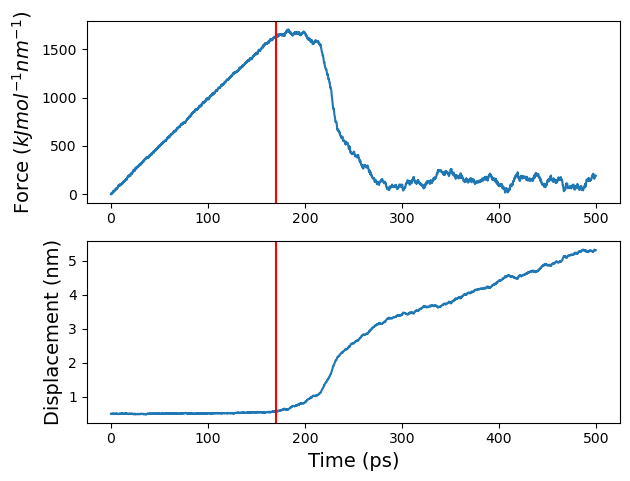

In [2]:
import matplotlib.pyplot as plt 
import numpy as np

#load data
data_f=np.loadtxt("02-pull/pull_pullf.xvg",comments=["#","@"])
data_d=np.loadtxt("02-pull/pull_pullx.xvg",comments=["#","@"])

# set variables for plot
time=data_f[:,0] 
force=data_f[:,1] 
displacement=data_d[:,1] 

# plot with matplotlib
plot,axes=plt.subplots(2,1) 
axes[0].plot(time,force)
axes[1].plot(time,displacement)
axes[1].set_xlabel("Time (ps)",size=14) #assign the x label 
axes[0].set_ylabel("Force ($kJmol^{-1}nm^{-1}$)",size=14) #assign the y label
axes[1].set_ylabel("Displacement (nm)",size=14) #assign the y label
axes[0].axvline(x = 170, color = 'r', label = 'detach')
axes[1].axvline(x = 170, color = 'r', label = 'detach')
plt.tight_layout()
# if you want to save the figure, uncomment the following line
#plot.savefig("subplot_force_disp.png",format="png", dpi=300)

Usually we are interested in the force-displacemnt graph, which allow you to estimate some mechanical properties of the system. 

**Plot the force-displacement graph using matplotlib.**

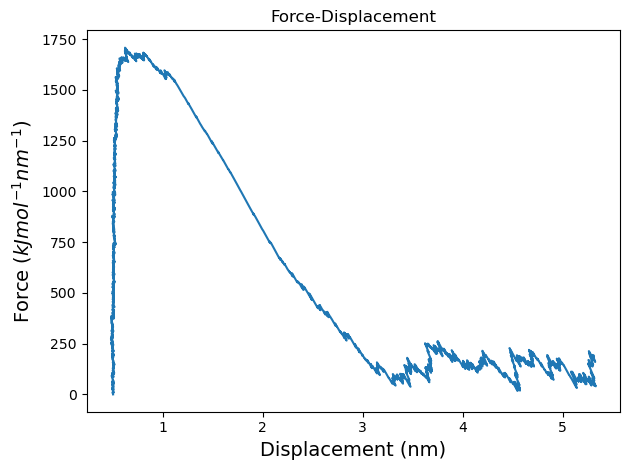

In [5]:
plt.plot(displacement,force)
plt.xlabel("Displacement (nm)",size=14) 
plt.ylabel("Force ($kJmol^{-1}nm^{-1}$)",size=14) 
plt.title("Force-Displacement")
plt.tight_layout()
# uncomment the following line to save the figure
#plt.savefig("force-displacement.png",format="png", dpi=300)

We are also interested in evaluating the energy difference $\Delta G$ between state A (bound state) and state B (un-bound state). 

Remember the **Jarzinski equality**: 

$$\left<e^{-\beta {W}}\right>=e^{-\beta \Delta G} \Longleftrightarrow \Delta G=-\frac{1}{\beta} \ln \left<e^{-\beta {W}}\right>$$


We can extract **equilibrium information ΔG** from the ensemble of **non-equilibrium (finite-time) measurements**.

**Note:** We should run multiple indipendent SMD simulation to properly evaluate the average of the WORK to go from A to B. For this exercise, we will only use a single SMD simulation for simplicity.

In [3]:
# evaluate work done by the force
import numpy as np
work = np.trapz(force,displacement)

# calculate the free energy
temperature = 300 # K
boltzmann = 8.314 # J/mol/K
beta = 1/(boltzmann*temperature)
free_energy = -1/beta*np.log(np.exp(-beta*work))

In [4]:
# print the results
print(f"Work done by the force {work:.2f} kJ/mol")
print(f"ΔG = {free_energy:.2f} kJ/mol")

Work done by the force 2818.49 kJ/mol
ΔG = 2818.49 kJ/mol


Note that in this case the free energy is equal to the work done since we only perform a single simulation.